In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers, models, applications


In [ ]:
#checking normal path

In [2]:
data_folder = 'train'
data_folder_var_dict = {}
for folder in os.listdir(data_folder):
    if not folder.endswith(('.csv','.txt')):
        folder_path = os.path.join(data_folder,folder)
        folder_path = folder_path.replace("\\","/")
        data_folder_var_dict[f'{folder}'] = folder_path

In [3]:
#data preparation

In [4]:
data_folder = 'train'
flower_types = os.listdir(data_folder)

# Define possible colors
colors = ['red', 'white', 'yellow', 'pink', 'purple']

# Simulated oil concentration ranges (example values)
def simulate_oil_values(flower_type):
    ranges = {
        'rose': (0.2, 1.2),
        'daisy': (0.1, 0.6),
        'tulip': (0.1, 0.8)
    }
    low, high = ranges.get(flower_type, (0.1, 1.0))
    return {
        'Linalool': round(random.uniform(low, high), 3),
        'Geraniol': round(random.uniform(low, high), 3),
        'Citronellol': round(random.uniform(low, high), 3),
    }

# Build DataFrame
image_data = []
for flower_type in flower_types:
    folder_path = os.path.join(data_folder, flower_type)
    for image_file in os.listdir(folder_path):
        if image_file.lower().endswith(('jpg', 'png', 'jpeg')):
            image_path = os.path.join(folder_path, image_file).replace("\\", "/")
            oil_data = simulate_oil_values(flower_type)
            image_data.append({
                'image_path': image_path,
                'flower_type': flower_type,
                'color': random.choice(colors),
                **oil_data
            })

df = pd.DataFrame(image_data)
# df.to_csv("flower_metadata.csv", index=False

In [5]:
df

,image_path,flower_type,color,Linalool,Geraniol,Citronellol
0,train/daisy/10140303196_b88d3d6cec.jpg,daisy,yellow,0.424,0.382,0.259
1,train/daisy/10172379554_b296050f82_n.jpg,daisy,yellow,0.211,0.162,0.322
2,train/daisy/10172567486_2748826a8b.jpg,daisy,red,0.418,0.530,0.111
3,train/daisy/10172636503_21bededa75_n.jpg,daisy,pink,0.417,0.562,0.478
4,train/daisy/10391248763_1d16681106_n.jpg,daisy,white,0.569,0.360,0.186
...,...,...,...,...,...,...
1600,train/tulip/9831362123_5aac525a99_n.jpg,tulip,white,0.800,0.436,0.330
1601,train/tulip/9870557734_88eb3b9e3b_n.jpg,tulip,pink,0.552,0.606,0.711
1602,train/tulip/9947374414_fdf1d0861c_n.jpg,tulip,purple,0.113,0.106,0.728
1603,train/tulip/9947385346_3a8cacea02_n.jpg,tulip,red,0.778,0.317,0.658


In [6]:
df.to_csv("flower_metadata.csv", index=False)

In [7]:
# Create label mappings
flower_type_to_idx = {name: idx for idx, name in enumerate(df['flower_type'].unique())}
color_to_idx = {name: idx for idx, name in enumerate(df['color'].unique())}

# Apply label mappings
df['flower_label'] = df['flower_type'].map(flower_type_to_idx)
df['color_label'] = df['color'].map(color_to_idx)

# Convert DataFrame columns to lists
image_paths = df['image_path'].tolist()
labels = df['flower_label'].tolist()  # You can use `color_label` if needed

In [8]:
#func

In [9]:
# Define image loading function
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Convert to tf.data.Dataset
def create_dataset(image_paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create the dataset
train_dataset = create_dataset(image_paths, labels)

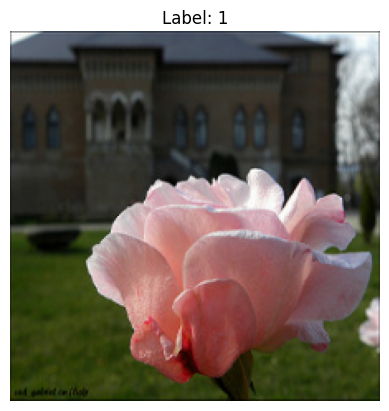

In [10]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    plt.imshow(images[1].numpy())
    plt.title(f"Label: {labels[1].numpy()}")
    plt.axis('off')
    plt.show()

In [11]:
#base model

In [15]:
#train_test

In [16]:

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['flower_label'], random_state=42)


In [29]:
train_labels = list(zip(
    train_df['image_path'].tolist(),

    train_df['flower_label'].tolist(),
    train_df['color_label'].tolist(),
    train_df[['Linalool', 'Geraniol', 'Citronellol']].values.tolist()
))

val_labels = list(zip(
    val_df['image_path'].tolist(),

    val_df['flower_label'].tolist(),
    val_df['color_label'].tolist(),
    val_df[['Linalool', 'Geraniol', 'Citronellol']].values.tolist()
))

In [30]:
def create_dataset(data, batch_size=32, shuffle=True):
    def gen():
        for path, flower_label, color_label, oil_values in data:
            yield path, (flower_label, color_label, oil_values)

    def load_image(path, labels):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0

        flower_label = tf.cast(labels[0], tf.int32)
        color_label = tf.cast(labels[1], tf.int32)
        oil_values = tf.cast(labels[2], tf.float32)

        return image, {
            'flower_output': flower_label,
            'color_output': color_label,
            'oil_output': oil_values
        }

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            (
                tf.TensorSpec(shape=(), dtype=tf.int32),      # flower label
                tf.TensorSpec(shape=(), dtype=tf.int32),      # color label
                tf.TensorSpec(shape=(3,), dtype=tf.float32),  # oil values
            )
        )
    )
    
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [31]:
train_dataset = create_dataset(train_labels)
val_dataset = create_dataset(val_labels, shuffle=False)


In [32]:
print(train_labels[0])

('train/tulip/14066056226_d8564a083e_m.jpg', 2, 1, [0.101, 0.139, 0.735])


In [49]:
#load pretrained RESNET

In [33]:

base_model = applications.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(224, 224, 3), pooling='avg'
)
base_model.trainable = False  # freeze pretrained ResNet initially

inputs = layers.Input(shape=(224, 224, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = base_model(x)

flower_output = layers.Dense(num_flower_classes, activation='softmax', name='flower_output')(x)
color_output = layers.Dense(num_color_classes, activation='softmax', name='color_output')(x)
oil_output = layers.Dense(3, activation='linear', name='oil_output')(x)

model = models.Model(inputs=inputs, outputs=[flower_output, color_output, oil_output])

model.compile(
    optimizer='adam',
    loss={
        'flower_output': 'sparse_categorical_crossentropy',
        'color_output': 'sparse_categorical_crossentropy',
        'oil_output': 'mse'
    },
    metrics={
        'flower_output': 'accuracy',
        'color_output': 'accuracy',
        'oil_output': 'mae'
    }
)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_flower_output_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]


In [35]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,               # You can increase this
    callbacks=callbacks
)


Epoch 1/20
41/41 [==============================] - 195s 4s/step - loss: 2.9490 - flower_output_loss: 1.1241 - color_output_loss: 1.6626 - oil_output_loss: 0.1623 - flower_output_accuracy: 0.3754 - color_output_accuracy: 0.2064 - oil_output_mae: 0.3072 - val_loss: 2.8003 - val_flower_output_loss: 1.1034 - val_color_output_loss: 1.6133 - val_oil_output_loss: 0.0836 - val_flower_output_accuracy: 0.3832 - val_color_output_accuracy: 0.2336 - val_oil_output_mae: 0.2303 - lr: 0.0010
Epoch 2/20
41/41 [==============================] - 187s 4s/step - loss: 2.7936 - flower_output_loss: 1.0885 - color_output_loss: 1.6296 - oil_output_loss: 0.0755 - flower_output_accuracy: 0.3746 - color_output_accuracy: 0.2118 - oil_output_mae: 0.2195 - val_loss: 2.8098 - val_flower_output_loss: 1.0988 - val_color_output_loss: 1.6349 - val_oil_output_loss: 0.0762 - val_flower_output_accuracy: 0.4019 - val_color_output_accuracy: 0.1807 - val_oil_output_mae: 0.2191 - lr: 0.0010
Epoch 3/20
41/41 [==================

In [ ]:
#model get stop bcoz no change in metric in range of 5

In [36]:
# model.save("multi_output_flower_model.h5")

In [37]:
results = model.evaluate(val_dataset)
print("Evaluation results:", results)

11/11 [==============================] - 31s 3s/step - loss: 2.7507 - flower_output_loss: 1.0487 - color_output_loss: 1.6282 - oil_output_loss: 0.0738 - flower_output_accuracy: 0.5171 - color_output_accuracy: 0.1931 - oil_output_mae: 0.2219
Evaluation results: [2.7507245540618896, 1.0487457513809204, 1.6281949281692505, 0.07378388196229935, 0.5171339511871338, 0.19314642250537872, 0.22194141149520874]


In [38]:
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    
    flower_preds = tf.argmax(predictions[0], axis=1).numpy()
    color_preds = tf.argmax(predictions[1], axis=1).numpy()
    oil_preds = predictions[2]

    true_flower = labels['flower_output'].numpy()
    true_color = labels['color_output'].numpy()
    true_oils = labels['oil_output'].numpy()
    
    for i in range(5):  # Show first 5 samples
        print(f"\n🖼 Sample {i + 1}")
        print(f"Flower (true/pred): {true_flower[i]} / {flower_preds[i]}")
        print(f"Color  (true/pred): {true_color[i]} / {color_preds[i]}")
        print(f"Oil    (true/pred): {true_oils[i]} / {oil_preds[i]}")


1/1 [==============================] - 7s 7s/step

🖼 Sample 1
Flower (true/pred): 0 / 1
Color  (true/pred): 4 / 1
Oil    (true/pred): [0.411 0.403 0.285] / [0.5367319 0.653946  0.5744798]

🖼 Sample 2
Flower (true/pred): 0 / 1
Color  (true/pred): 3 / 1
Oil    (true/pred): [0.298 0.315 0.591] / [0.4925284  0.56396145 0.5030229 ]

🖼 Sample 3
Flower (true/pred): 2 / 0
Color  (true/pred): 1 / 1
Oil    (true/pred): [0.778 0.317 0.658] / [0.4637503 0.5291922 0.514102 ]

🖼 Sample 4
Flower (true/pred): 2 / 2
Color  (true/pred): 1 / 1
Oil    (true/pred): [0.207 0.218 0.363] / [0.48130023 0.55689204 0.5146226 ]

🖼 Sample 5
Flower (true/pred): 0 / 1
Color  (true/pred): 2 / 1
Oil    (true/pred): [0.586 0.268 0.244] / [0.5390844 0.6301905 0.5753528]


In [39]:
idx_to_flower = {v: k for k, v in flower_type_to_idx.items()}
idx_to_color = {v: k for k, v in color_to_idx.items()}

print(f"Flower label name: {idx_to_flower[flower_preds[i]]}")
print(f"Color label name: {idx_to_color[color_preds[i]]}")


Flower label name: rose
Color label name: red


In [41]:
#metric

In [42]:

y_true_flower = []
y_pred_flower = []
y_true_color = []
y_pred_color = []
y_true_oil = []
y_pred_oil = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)

    # Flower predictions
    flower_pred = np.argmax(preds[0], axis=1)
    flower_true = labels['flower_output'].numpy()

    # Color predictions
    color_pred = np.argmax(preds[1], axis=1)
    color_true = labels['color_output'].numpy()

    # Oil predictions
    oil_pred = preds[2]
    oil_true = labels['oil_output'].numpy()

    # Accumulate all predictions and truths
    y_pred_flower.extend(flower_pred)
    y_true_flower.extend(flower_true)
    y_pred_color.extend(color_pred)
    y_true_color.extend(color_true)
    y_pred_oil.extend(oil_pred)
    y_true_oil.extend(oil_true)

In [43]:

print("🌸 Flower Classification:")
print("Accuracy:", accuracy_score(y_true_flower, y_pred_flower))
print("F1 Score (macro):", f1_score(y_true_flower, y_pred_flower, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_true_flower, y_pred_flower))

print("\n🎨 Color Classification:")
print("Accuracy:", accuracy_score(y_true_color, y_pred_color))
print("F1 Score (macro):", f1_score(y_true_color, y_pred_color, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_true_color, y_pred_color))


🌸 Flower Classification:
Accuracy: 0.5171339563862928
F1 Score (macro): 0.516326380207413
Confusion Matrix:
 [[48 33 19]
 [24 56 20]
 [22 37 62]]

🎨 Color Classification:
Accuracy: 0.19314641744548286
F1 Score (macro): 0.08005021600265849
Confusion Matrix:
 [[ 0 69  3  0  0]
 [ 0 59  2  1  0]
 [ 0 59  3  0  0]
 [ 0 67  0  0  0]
 [ 0 55  3  0  0]]


In [44]:

y_true_oil = np.array(y_true_oil)
y_pred_oil = np.array(y_pred_oil)

print("\n🧪 Oil Regression:")
print("MAE:", mean_absolute_error(y_true_oil, y_pred_oil))
print("MSE:", mean_squared_error(y_true_oil, y_pred_oil))
print("R² Score:", r2_score(y_true_oil, y_pred_oil))



🧪 Oil Regression:
MAE: 0.22194136679172516
MSE: 0.07378387451171875
R² Score: -0.0682406798005104


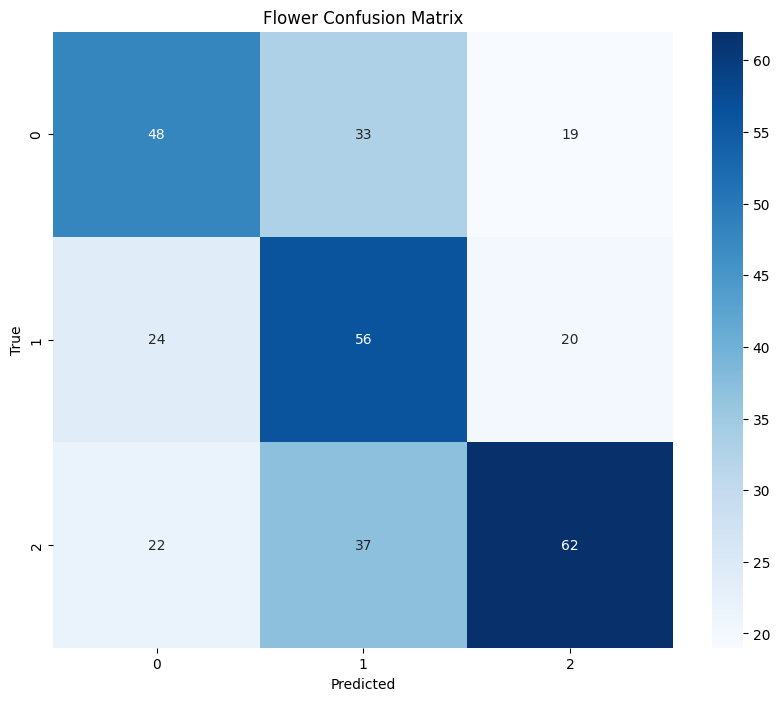

In [45]:
cm = confusion_matrix(y_true_flower, y_pred_flower)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Flower Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
